## Predictive Modelling : Multiclassification Problem

## Import of necessary Libraries

In [79]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
# Import libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, make_scorer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, plot_importance


from sklearn.metrics import roc_curve, confusion_matrix,precision_recall_curve,confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, fbeta_score, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Modeling
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV,RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


## Dashboard

In [117]:
scoring = ['precision_weighted']
RSEED = 42
pd.set_option('display.max_columns', 50)
random_state = 100
test_size = 0.3

compare_mod = pd.DataFrame()
def model_eval(m, X_train, X_test, y_train, y_test,name, df=compare_mod):
    
    """
    Function for calculating the metrics for a model to compare their performance.
    """
    
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]

    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
        
    df.at['test  recall', name] = recall_score(y_test, y_outs_pred, average='weighted')
    df.at['train recall', name] = recall_score(y_train, y_ins_pred, average='weighted')
    
    df.at['test  precision', name] = precision_score(y_test, y_outs_pred, average='weighted')
    df.at['train precision', name] = precision_score(y_train, y_ins_pred, average='weighted')
    
    df.at['test  f1', name] = f1_score(y_test, y_outs_pred,average='weighted')
    df.at['train f1', name] = f1_score(y_train, y_ins_pred,average='weighted')
     
    df.at['test  accuracy', name] = accuracy_score(y_test, y_outs_pred)
    df.at['train accuracy', name] = accuracy_score(y_train, y_ins_pred)    
    
    print('--')
    print(f'test  recall = {recall_score(y_test, y_outs_pred,average="weighted")}')
    print(f'train recall = {recall_score(y_train, y_ins_pred,average="weighted")}')
    print('--')
    print(f'test  precision = {precision_score(y_test, y_outs_pred,average="weighted")}')
    print(f'train precision = {precision_score(y_train, y_ins_pred,average="weighted")}')
    print('--')
    print(f'test  accuracy = {accuracy_score(y_test, y_outs_pred)}')
    print(f'train accuracy = {accuracy_score(y_train, y_ins_pred)}')
    print('--')  
    confusion = confusion_matrix(y_test, y_outs_pred,normalize='true',labels=[0, 1, 2])
    ax= plt.subplot()
    sns.heatmap(confusion, cmap="YlGnBu", annot=True, linewidths=.5);
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.xaxis.set_ticklabels(['defect', 'repairs','functional']); ax.yaxis.set_ticklabels(['defect','repairs','functional']);

## Import of Dataset and Set-Up

In [3]:
# Import of dataset after cleaning
df = pd.read_csv('data/df_model.csv')



In [4]:
# Converting Labels  
target_status_group = {'functional':2, 'functional needs repair': 1, 'non functional' : 0}
df['status_group'] = df['status_group'].replace(target_status_group)

In [5]:
df['status_group'].value_counts()

2    32259
0    22824
1     4317
Name: status_group, dtype: int64

In [6]:
# Define predictors and target variable
X = df.drop(["status_group",'lga','recorded_by'], axis=1)
y = df["status_group"]

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True,
                                                   stratify=y)

In [8]:
X_train.shape


(41580, 20)

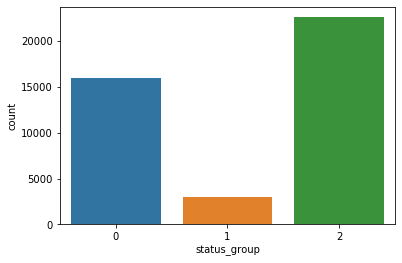

In [9]:
sns.countplot(y_train)

## Pipeline for preprocessing

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
amount_tsh           59400 non-null float64
gps_height           59400 non-null float64
longitude            59400 non-null float64
latitude             59400 non-null float64
basin                59400 non-null object
region               59400 non-null object
lga                  59400 non-null object
public_meeting       59400 non-null object
recorded_by          59400 non-null object
scheme_management    59400 non-null object
permit               59400 non-null object
construction_year    59400 non-null int64
payment_type         59400 non-null object
quality_group        59400 non-null object
quantity             59400 non-null object
source               59400 non-null object
waterpoint_type      59400 non-null object
status_group         59400 non-null int64
funder_cat           59400 non-null object
installer_cat        59400 non-null object
extraction_custom    59400 no

In [11]:
# Creating list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline") 
cat_features = list(df.columns[df.dtypes==object])
#cat_features.remove('status_group')
cat_features

['basin',
 'region',
 'lga',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'payment_type',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type',
 'funder_cat',
 'installer_cat',
 'extraction_custom',
 'management_custom']

In [12]:
#cat_features.remove('permit')
#cat_features.remove('public_meeting')
cat_features.remove('lga')
#cat_features.remove('ward')
cat_features.remove('recorded_by')
#cat_features.remove('region_code')
#num_features.remove('num_private')

In [13]:
cat_features

['basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'payment_type',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type',
 'funder_cat',
 'installer_cat',
 'extraction_custom',
 'management_custom']

In [14]:
# Creating list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features = list(df.columns[df.dtypes!=object])
num_features.remove('status_group')
#num_features.remove('district_code')
#num_features.remove('population')
#num_features.remove('region_code')
num_features
#cat_features.remove('status_group')

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'construction_year',
 'population_log']

In [15]:
# Pipeline using Pipeline
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(sparse=False))
])

# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [16]:
# transforming the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [17]:
print('train shape: ', X_train_transformed.shape)
print('validation shape: ',X_test_transformed.shape)

train shape:  (41580, 144)
validation shape:  (17820, 144)


In [18]:
hot_encoder = preprocessor.named_transformers_["cat"]['1hot']
hot_encoder_names = hot_encoder.get_feature_names(cat_features)
column_names = num_features + list(hot_encoder_names)

## Baseline Model: Dummy Classifier

In [19]:
# DummyClassifier for multiclass target variable 
dummy = DummyClassifier(strategy='most_frequent', random_state=0)
dummy.fit(X_train_transformed, y_train)
dummy.score(X_test_transformed, y_test)

0.5430976430976431

In [20]:
metrics = ['accuracy', 'precision_weighted', 'recall_weighted']
scores_dummy = cross_validate(dummy, X_train_transformed, y_train, scoring=metrics, cv=5, n_jobs=-1)
print('Mean accuracy: {:.2f}%'.format(scores_dummy['test_accuracy'].mean()*100))
print('Mean precision: {:.2f}%'.format(scores_dummy['test_precision_weighted'].mean()*100))
print('Mean recall: {:.2f}%'.format(scores_dummy['test_recall_weighted'].mean()*100))

Mean accuracy: 54.31%
Mean precision: 29.49%
Mean recall: 54.31%


## Classification Models

In [21]:

# Select models for comparison
models={'Baseline': DummyClassifier(strategy='most_frequent'),
        'LogReg': LogisticRegression(max_iter=100),
        #'KNN': KNeighborsClassifier(),
        #'SVC': SVC(kernel='rbf', C=1E6),
        'Decision Tree': DecisionTreeClassifier(criterion="gini", max_depth=3,random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state, max_features='sqrt', n_jobs=-1),
        #'Gradient Boost': GradientBoostingClassifier(random_state=random_state),
        'XGBoost': XGBClassifier(),
        'AdaBoost': AdaBoostClassifier(random_state=random_state)
        
       }

In [22]:
#scores = cross_validate(models, X_train, y_train, scoring=scoring, cv=3, n_jobs=-1, verbose=10)
# Calculate and display results
results = pd.DataFrame(columns=['Model'])
i = 0
for m in models.items():
       
    # Building a full pipeline with our preprocessor and a Classifier
    pipeline = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
    # Making predictions on the training set using cross validation as well as calculating the probabilities
    y_train_pred = cross_val_predict(pipeline,
                                        X_train,
                                        y_train.values.ravel(),
                                        cv=5,
                                        verbose=4,
                                        n_jobs=-1)
    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model': m[0],
            'Accuracy': accuracy_score(y_train, y_train_pred),
            'Recall': recall_score(y_train, y_train_pred, average="weighted"),
            'Precision': precision_score(y_train, y_train_pred, average="weighted"),
            'F1 Score': f1_score(y_train, y_train_pred, average="weighted")
            
        },
        index=[i])
    print(f"Confusion Matrix {m[0]}: \n" + str(confusion_matrix(y_train, y_train_pred)))
    i += 1
    results = pd.concat([results, temp])
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Baseline: 
[[    0     0 15977]
 [    0     0  3022]
 [    0     0 22581]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix LogReg: 
[[10235   124  5618]
 [  573   293  2156]
 [ 2241   121 20219]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Decision Tree: 
[[ 8638     0  7339]
 [  683     0  2339]
 [ 2228     0 20353]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix Random Forest: 
[[12431   270  3276]
 [  467  1034  1521]
 [ 2214   676 19691]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix XGBoost: 
[[ 9771    85  6121]
 [  382   304  2336]
 [ 1407    92 21082]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.1s remaining:   12.1s


Confusion Matrix AdaBoost: 
[[ 9907   139  5931]
 [  553   222  2247]
 [ 2370   170 20041]]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.2s finished
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Accuracy,F1 Score,Model,Precision,Recall
0,0.543074,0.382262,Baseline,0.294929,0.543074
1,0.739466,0.717177,LogReg,0.733222,0.739466
2,0.697234,0.661340,Decision Tree,0.655454,0.697234
3,0.797403,0.791715,Random Forest,0.790723,0.797403
4,0.749327,0.724636,XGBoost,0.758308,0.749327
5,0.725589,0.701868,AdaBoost,0.712780,0.725589


## Logistic Regression

In [23]:
# Logistic regression (using pipeline)
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [24]:
y_train_pred = cross_val_predict(pipeline_logreg,X_train,y_train,cv=5)

In [25]:
# Logistic regression (using pipeline, printing results)
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_pred,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_train_pred,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_train_pred)))


Cross validation scores:
-------------------------
Accuracy: 0.74
Recall: 0.74
Precision: 0.73
F1 Score: 0.72
Confusion Matrix: 
[[10262   119  5596]
 [  580   292  2150]
 [ 2251   121 20209]]


### Hyperparameter Tunig with Grid Seach

In [26]:
# Defining hyperparameters for grid-search (C initial: [0.01, 0.1, 1, 10, 100]; adapted according to optimal results)
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.05, 0.08, 0.1, 0.2, 0.5, 1],
                'logreg__class_weight': [{0: x, 1: 1.0-x} for x in [0.25,0.5,0.75]]
               }

grid_logreg = GridSearchCV(pipeline_logreg, param_grid=param_logreg, cv=5, scoring=scoring, 
                           verbose=5, n_jobs=-1, refit='precision_weighted',return_train_score=True) # scoring can also be "precision", "recall", ...

In [27]:
# Fit model
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'longitude',
                                                                          'latitude',
                                                                          'construction_year',
                                                                          'population_log']),
                                                                        ('cat',
            

In [28]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.76
Best parameters:
{'logreg__C': 0.5, 'logreg__class_weight': {0: 0.75, 1: 0.25}, 'logreg__penalty': 'l2'}


In [29]:
# Save best model as best_model
best_model_logreg = grid_logreg.best_estimator_['logreg']

In [30]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_pred_logreg = best_model_logreg.predict(X_test_transformed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_logreg)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_logreg,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_logreg,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_logreg,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_logreg)))

Accuracy: 0.73
Recall: 0.73
Precision: 0.75
F1 Score: 0.70
Confusion Matrix: 
[[4052    0 2795]
 [ 186    4 1105]
 [ 668    1 9009]]


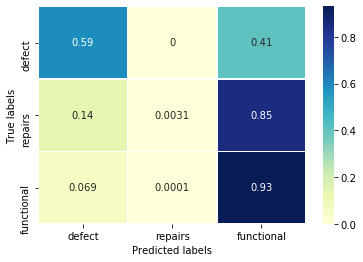

In [112]:
confusion = confusion_matrix(y_test, y_pred_logreg,normalize='true',labels=[0, 1, 2])
ax= plt.subplot()
sns.heatmap(confusion, cmap="YlGnBu", annot=True, linewidths=.5);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.xaxis.set_ticklabels(['defect', 'repairs','functional']); ax.yaxis.set_ticklabels(['defect','repairs','functional']);
plt.savefig("figures/Confusion_LG.png")

## Random Forest

In [32]:
# Create model
pipeline_rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_clf', RandomForestClassifier(n_estimators=100,
                              random_state=random_state,
                              max_depth=5,
                              max_features="sqrt",
                              n_jobs=-1,
                              class_weight='balanced',
                              criterion= 'entropy',
                              min_samples_split= 10))
])

In [33]:
y_train_pred_rf_clf = cross_val_predict(pipeline_rf_clf, X_train, y_train, cv=5)

In [34]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred_rf_clf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_pred_rf_clf,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred_rf_clf,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_train_pred_rf_clf,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_train_pred_rf_clf)))

Cross validation scores:
-------------------------
Accuracy: 0.64
Recall: 0.64
Precision: 0.73
F1 Score: 0.67
Confusion Matrix: 
[[ 9268  2382  4327]
 [  347  1730   945]
 [ 1961  4835 15785]]


### Hyperparameter Tunig with Grid Seach

In [35]:
# Defining hyperparameter space for grid-search
param_grid = {'rf_clf__bootstrap': [True, False],
              'rf_clf__max_depth': [2, 3, 5, 10, 20, 30,50,None],
              'rf_clf__max_features': ['auto', 'sqrt',3,5,10,20],
              'rf_clf__min_samples_leaf': [1, 2, 4],
              'rf_clf__min_samples_split': [2, 5, 10],
              'rf_clf__n_estimators': [10, 50, 100, 200, 400]} # Others: kernel, degree (only for poly)
grid_rf_clf = RandomizedSearchCV(pipeline_rf_clf, param_grid, cv=5, scoring=scoring, 
                           verbose=10, n_jobs=-1, refit='precision_weighted',return_train_score=True, n_iter=50)

In [36]:
# Fit on training data
grid_rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  8

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['amount_tsh',
                                                                                'gps_height',
                                                                                'longitude',
                                                                                'latitude',
                                                                                'construction_year',
                                                                                'population_log']),
                          

In [37]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_rf_clf.best_score_))
print("Best parameters:\n{}".format(grid_rf_clf.best_params_))

Best score:
0.80
Best parameters:
{'rf_clf__n_estimators': 200, 'rf_clf__min_samples_split': 5, 'rf_clf__min_samples_leaf': 4, 'rf_clf__max_features': 20, 'rf_clf__max_depth': 20, 'rf_clf__bootstrap': False}


In [38]:
# Save best model as best_model
best_model_rf_clf = grid_rf_clf.best_estimator_['rf_clf']

In [39]:
y_pred_rf_clf = best_model_rf_clf.predict(X_test_transformed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_rf_clf)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_rf_clf,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_rf_clf,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf_clf,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_rf_clf)))

Accuracy: 0.77
Recall: 0.77
Precision: 0.80
F1 Score: 0.78
Confusion Matrix: 
[[5168  457 1222]
 [ 130  839  326]
 [ 778 1262 7638]]


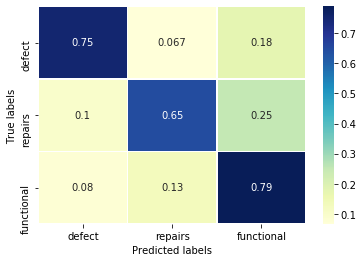

In [114]:
confusion = confusion_matrix(y_test, y_pred_rf_clf,normalize='true',labels=[0, 1, 2])
ax= plt.subplot()
sns.heatmap(confusion, cmap="YlGnBu", annot=True, linewidths=.5);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.xaxis.set_ticklabels(['defect', 'repairs','functional']); ax.yaxis.set_ticklabels(['defect','repairs','functional']);
plt.savefig("figures/Confusion_RF.png")

## XGBoost

In [41]:
# Preprocessing pipeline
pipe_xgb = Pipeline([('preprocess', preprocessor), 
                     ('xgb', XGBClassifier(random_state=RSEED))
                    ])

In [42]:
y_train_pred_xgb_clf = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)

In [43]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred_xgb_clf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_pred_xgb_clf,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred_xgb_clf,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_train_pred_xgb_clf,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_train_pred_xgb_clf)))

Cross validation scores:
-------------------------
Accuracy: 0.75
Recall: 0.75
Precision: 0.76
F1 Score: 0.72
Confusion Matrix: 
[[ 9771    85  6121]
 [  382   304  2336]
 [ 1407    92 21082]]


### Hyperparameter Tunig with Grid Seach

In [44]:
param_xgb = {"xgb__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
             "xgb__max_depth": [5, 6, 8, 10, 12, 15, 17, 20],
             "xgb__min_child_weight": [1, 3, 5],
             "xgb__gamma": [0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "xgb__colsample_bytree" : [0.4, 0.5 , 0.7 ] 
            }


In [45]:
# First RandomSearch for XGBoost
grid_xgb = RandomizedSearchCV(pipe_xgb, 
                                param_distributions = param_xgb,
                                n_iter = 50, cv = 3, scoring = scoring, 
                                verbose = 10, random_state=RSEED, n_jobs = -1,refit='precision_weighted',return_train_score=True,)

In [46]:
grid_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 56.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 67.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 75.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 85.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 93.5min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['amount_tsh',
                                                                                'gps_height',
                                                                                'longitude',
                                                                                'latitude',
                                                                                'construction_year',
                                                                                'population_log']),
                            

In [47]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_xgb.best_score_))
print("Best parameters:\n{}".format(grid_xgb.best_params_))

Best score:
0.80
Best parameters:
{'xgb__min_child_weight': 1, 'xgb__max_depth': 12, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.3, 'xgb__colsample_bytree': 0.5}


In [48]:
# Save best model as best_model
best_model_xgb_clf = grid_xgb.best_estimator_['xgb']

In [49]:
y_pred_xgb_clf = best_model_xgb_clf.predict(X_test_transformed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_xgb_clf)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_xgb_clf,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_xgb_clf,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_xgb_clf,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_xgb_clf)))

Accuracy: 0.81
Recall: 0.81
Precision: 0.81
F1 Score: 0.79
Confusion Matrix: 
[[5111   51 1685]
 [ 195  331  769]
 [ 670   91 8917]]


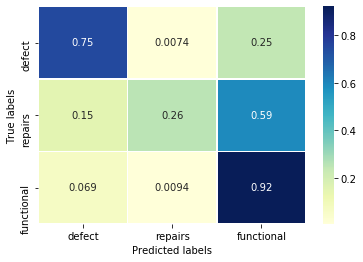

In [115]:
confusion = confusion_matrix(y_test, y_pred_xgb_clf,normalize='true',labels=[0, 1, 2])
ax= plt.subplot()
sns.heatmap(confusion, cmap="YlGnBu", annot=True, linewidths=.5);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.xaxis.set_ticklabels(['defect', 'repairs','functional']); ax.yaxis.set_ticklabels(['defect','repairs','functional']);
plt.savefig("figures/Confusion_XGBOOST.png")

## : SMOTE

In [51]:
k=1
seed=100
sm = SMOTE(sampling_strategy='minority',random_state=seed)
X_train_new, y_train_new = sm.fit_sample(X_train_transformed, y_train)
X_res_tes, y_res_test = sm.fit_resample(X_test_transformed, y_test)

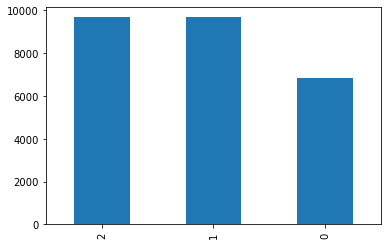

In [52]:
pd.Series(y_res_test).value_counts().plot.bar()

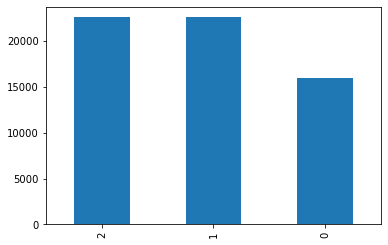

In [53]:

# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [54]:
from imblearn.pipeline import Pipeline

In [55]:
pipeline_smote = Pipeline([('smote', SMOTE(sampling_strategy='minority')),
                     ('xgb', XGBClassifier(random_state=RSEED))])


In [56]:
y_train_pred_xgb_clf_smote = cross_val_predict(pipeline_smote, X_train_new, y_train_new, cv=5)

In [57]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train_new, y_train_pred_xgb_clf_smote)))
print("Recall: {:.2f}".format(recall_score(y_train_new, y_train_pred_xgb_clf_smote,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_train_new, y_train_pred_xgb_clf_smote,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_train_new, y_train_pred_xgb_clf_smote,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train_new, y_train_pred_xgb_clf_smote)))

Cross validation scores:
-------------------------
Accuracy: 0.73
Recall: 0.73
Precision: 0.73
F1 Score: 0.73
Confusion Matrix: 
[[10058  1872  4047]
 [ 1484 18082  3015]
 [ 1966  4149 16466]]


### Hyperparameter Tunig with Grid Seach

In [58]:
param_xgb_smote = {"xgb__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
             "xgb__max_depth": [5, 6, 8, 10, 12, 15, 17, 20],
             "xgb__min_child_weight": [1, 3, 5],
             "xgb__gamma": [0.0, 0.1, 0.2 , 0.3, 0.4 ],
             "xgb__colsample_bytree" : [0.4, 0.5 , 0.7 ] 
            }


In [59]:
# First RandomSearch for XGBoost
grid_xgb_smote = RandomizedSearchCV(pipeline_smote, 
                                param_distributions = param_xgb_smote,
                                n_iter = 50, cv = 3, scoring = scoring, 
                                verbose = 10, random_state=RSEED, n_jobs = -1,refit='precision_weighted',return_train_score=True)

In [60]:
grid_xgb_smote.fit(X_train_new, y_train_new)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 79.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 92.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 102.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 122.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 138.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 156.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 170.2min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(sampling_strategy='minority')),
                                             ('xgb',
                                              XGBClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.4, 0.5,
                                                                  0.7],
                                        'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'xgb__learning_rate': [0.05, 0.1, 0.15,
                                                               0.2, 0.25, 0.3],
                                        'xgb__max_depth': [5, 6, 8, 10, 12, 15,
                                                           17, 20],
                                        'xgb__min_child_weight': [1, 3, 5]},
                   random_state=42, refit='prec

In [61]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_xgb_smote.best_score_))
print("Best parameters:\n{}".format(grid_xgb_smote.best_params_))

Best score:
0.86
Best parameters:
{'xgb__min_child_weight': 1, 'xgb__max_depth': 20, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.4, 'xgb__colsample_bytree': 0.4}


In [62]:
# Save best model as best_model
best_model_xgb_smote_clf = grid_xgb_smote.best_estimator_['xgb']

In [63]:
y_pred_xgb_smote_clf = best_model_xgb_smote_clf.predict(X_test_transformed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_xgb_smote_clf)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_xgb_smote_clf,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_xgb_smote_clf,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_xgb_smote_clf,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_xgb_smote_clf)))

Accuracy: 0.81
Recall: 0.81
Precision: 0.80
F1 Score: 0.80
Confusion Matrix: 
[[5408  167 1272]
 [ 191  585  519]
 [ 874  450 8354]]


In [64]:
classifier=grid_xgb_smote

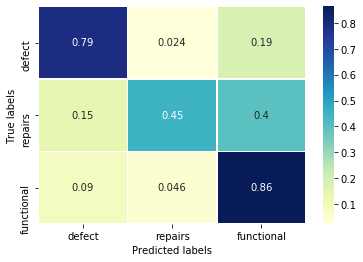

In [116]:
confusion = confusion_matrix(y_test, y_pred_xgb_smote_clf,normalize='true',labels=[0, 1, 2])
ax= plt.subplot()
sns.heatmap(confusion, cmap="YlGnBu", annot=True, linewidths=.5);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.xaxis.set_ticklabels(['defect', 'repairs','functional']); ax.yaxis.set_ticklabels(['defect','repairs','functional']);
plt.savefig("figures/Confusion_XGBOOST_SMOTE.png")

## Neural Network: Multilayer Perceptron Classifier (MCP)

In [67]:
from sklearn.neural_network import MLPClassifier

In [70]:
clf_neural = MLPClassifier(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(5, 2), random_state=1)
clf_neural.fit(X_train_new, y_train_new)

/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

--
test  recall = 0.6914857077433881
train recall = 0.7153862510018155
--
test  precision = 0.696265898935762
train precision = 0.7200212557068872
--
test  accuracy = 0.6914857077433881
train accuracy = 0.7153862510018155
--


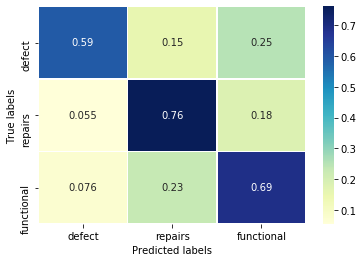

In [118]:
model_eval(clf_neural,X_train_new, X_res_tes, y_train_new,y_res_test,'SNN_MLP')


In [72]:
parameters = {'solver': ['lbfgs','adam'],
              'max_iter': [10,100,1000,1250,1500, 1750, 2000], 
              'alpha': 10.0 ** -np.arange(1, 10), 
              'hidden_layer_sizes':np.arange(10, 15)}
clf_grid = RandomizedSearchCV(MLPClassifier(random_state=42), parameters, n_jobs=-1)

clf_grid.fit(X_train_new, y_train_new)

/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RandomizedSearchCV(estimator=MLPClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09]),
                                        'hidden_layer_sizes': array([10, 11, 12, 13, 14]),
                                        'max_iter': [10, 100, 1000, 1250, 1500,
                                                     1750, 2000],
                                        'solver': ['lbfgs', 'adam']})

In [73]:
# Show best parameters
print('Best score:\n{:.2f}'.format(clf_grid.best_score_))
print("Best parameters:\n{}".format(clf_grid.best_params_))

Best score:
0.76
Best parameters:
{'solver': 'lbfgs', 'max_iter': 1250, 'hidden_layer_sizes': 13, 'alpha': 0.1}


--
test  recall = 0.6977063694996756
train recall = 0.778717348991642
--
test  precision = 0.703057113236236
train precision = 0.7810871525630929
--
test  accuracy = 0.6977063694996756
train accuracy = 0.778717348991642
--


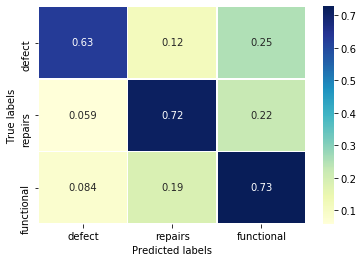

In [120]:
model_eval(clf_grid,X_train_new,X_res_tes,y_train_new,y_res_test,'MLP_RandomSearch')
plt.savefig("figures/Confusion_NN.png")

## Model Conclusion

Of all models, the MCP gave